# MovieLens Recommendation System


## Business Understanding


**Stakeholder:** A movie streaming platform’s product + personalization team.

**Real-world problem:** Users face choice overload; if they can’t quickly find movies they enjoy, engagement drops and churn risk increases.

**Project goal:** Build a recommendation system that predicts how a user would rate unseen movies and returns Top-5 personalized recommendations.

**How stakeholders would use it:**
- Populate a “Recommended for You” row on the homepage
- Improve email/push recommendations
- Support content discovery and retention efforts

**Success criteria:**
- Low prediction error (RMSE/MAE) on held-out ratings
- Recommendations that are plausible and relevant for sample users


In [41]:
# Imports + notebook settings (keep all imports in one place)
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from surprise import Dataset, Reader, accuracy
from surprise import BaselineOnly, KNNBaseline, SVD
from surprise.model_selection import cross_validate, GridSearchCV

# Optional: tighten markdown spacing (kept with imports/settings)
from IPython.display import HTML
HTML(r'''
<style>
.rendered_html p { margin: 0.35em 0; }
.rendered_html ul { margin: 0.35em 0 0.35em 1.2em; }
.rendered_html li { margin: 0.15em 0; }
</style>
''')

RANDOM_STATE = 42

# Paths (assumes this notebook lives in /notebooks and data is in data/)
DATA_DIR = Path("data/")

# Where to save figures (repo-friendly)
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)


## Data Understanding


I use the MovieLens “latest small” dataset (ml-latest-small) from GroupLens. It contains 100,836 ratings and 3,683 tag applications across 9,742 movies from 610 users. Ratings use a 0.5–5.0 scale. These explicit ratings are well-suited to collaborative filtering. 

**Limitations that matter for this project:**
- The user–movie matrix is sparse (most users rate only a small fraction of movies)
- Cold start exists for brand-new users and new movies
- No user demographics are included


## Data Exploration


In [42]:
# Load MovieLens data files
ratings = pd.read_csv(DATA_DIR / "ratings.csv")
movies  = pd.read_csv(DATA_DIR / "movies.csv")
links   = pd.read_csv(DATA_DIR / "links.csv")
tags    = pd.read_csv(DATA_DIR / "tags.csv")

ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [43]:
# Basic dataset Facts
print("ratings shape:", ratings.shape)
print("movies shape:", movies.shape)
print("tags shape:", tags.shape)

print("Unique users:", ratings["userId"].nunique())
print("Unique movies rated:", ratings["movieId"].nunique())
print("Rating scale:", ratings["rating"].min(), "to", ratings["rating"].max())

ratings["rating"].describe()


ratings shape: (100836, 4)
movies shape: (9742, 3)
tags shape: (3683, 4)
Unique users: 610
Unique movies rated: 9724
Rating scale: 0.5 to 5.0


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [44]:
# Checking for data Sparsity
n_users = ratings["userId"].nunique()
n_items = ratings["movieId"].nunique()
n_obs = len(ratings)

density = n_obs / (n_users * n_items)
sparsity = 1 - density

print(f"Users: {n_users}, Movies: {n_items}, Ratings: {n_obs}")
print(f"Matrix density: {density:.6f}")
print(f"Matrix sparsity: {sparsity:.6f}")


Users: 610, Movies: 9724, Ratings: 100836
Matrix density: 0.017000
Matrix sparsity: 0.983000


### Ratings Activity

To better understand sparsity, we examine how many ratings each user and each movie has.


In [45]:
# Ratings per user and per movie (descriptive properties)
ratings_per_user  = ratings.groupby("userId").size().rename("ratings_per_user")
ratings_per_movie = ratings.groupby("movieId").size().rename("ratings_per_movie")

display(ratings_per_user.describe().to_frame().T)
display(ratings_per_movie.describe().to_frame().T)


,count,mean,std,min,25%,50%,75%,max
ratings_per_user,610.0,165.304918,269.480584,20.0,35.0,70.5,168.0,2698.0


,count,mean,std,min,25%,50%,75%,max
ratings_per_movie,9724.0,10.369807,22.401005,1.0,1.0,3.0,9.0,329.0


To evaluate models fairly, we split ratings into a training set (for model selection) and a holdout test set (for final evaluation).

### Reproducibility Notes
- Run top-to-bottom with **Restart Kernel & Run All**
- Random seed is fixed using `RANDOM_STATE`
- Data is loaded from `data/` relative to the notebook location
- The holdout test set remains untouched until final evaluation


### Feature Justification

Collaborative filtering relies on user–item interactions:

- **userId** identifies the user  
- **movieId** identifies the movie  
- **rating** is the preference signal we predict  

We do not use **timestamp** in this baseline. A next step could explore time-aware recommendations.


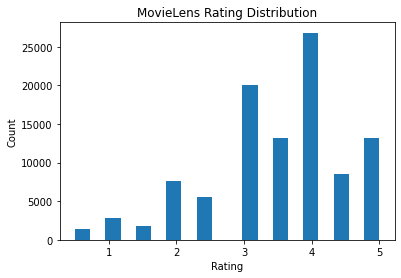

In [46]:
# Rating distribution plot
ratings["rating"].plot(kind="hist", bins=20)
plt.title("MovieLens Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


## Data Preparation


To evaluate models fairly, I split ratings into:

- Training set (80%): model fitting + cross-validation (model selection)

- Holdout test set (20%): final evaluation only

This prevents leakage and estimates real-world performance on unseen ratings.


In [47]:
# Splitting strategy to prevent leakage
train_df, test_df = train_test_split(
    ratings[["userId", "movieId", "rating"]],
    test_size=0.2,
    random_state=42
)

print("train_df:", train_df.shape, "test_df:", test_df.shape)


train_df: (80668, 3) test_df: (20168, 3)


In [48]:
# Suprise dataset objects
reader = Reader(rating_scale=(0.5, 5.0))

train_data = Dataset.load_from_df(train_df[["userId", "movieId", "rating"]], reader)
# testset must be a list of (uid, iid, true_rating)
testset = list(test_df.itertuples(index=False, name=None))  # (userId, movieId, rating)


## Modeling


**Modeling (Iterative approach:** Baseline → kNN → Matrix Factorization)

I follow an iterative modeling approach:

- 1. BaselineOnly: a simple benchmark that predicts ratings using global/user/movie biases.

- 2. KNNBaseline: neighborhood collaborative filtering using item-item similarity.

- 3. SVD (matrix factorization): learns latent factors representing user preferences and movie characteristics.

- 4. Tuned SVD: uses cross-validation to select hyperparameters for better generalization.


In [49]:
# Cross-validated model comparison on training data
def cv_rmse_mae(algo, data, cv=3):
    results = cross_validate(algo, data, measures=["RMSE", "MAE"], cv=cv, verbose=False)
    return np.mean(results["test_rmse"]), np.mean(results["test_mae"])

baseline_algo = BaselineOnly()
knn_algo = KNNBaseline(sim_options={"name": "pearson_baseline", "user_based": False})  # item-based CF
svd_algo = SVD(random_state=42)

baseline_rmse, baseline_mae = cv_rmse_mae(baseline_algo, train_data, cv=3)
knn_rmse, knn_mae = cv_rmse_mae(knn_algo, train_data, cv=3)
svd_rmse, svd_mae = cv_rmse_mae(svd_algo, train_data, cv=3)

print("CV Results (Train Only)")
print(f"BaselineOnly  RMSE={baseline_rmse:.4f}, MAE={baseline_mae:.4f}")
print(f"KNNBaseline   RMSE={knn_rmse:.4f}, MAE={knn_mae:.4f}")
print(f"SVD (default) RMSE={svd_rmse:.4f}, MAE={svd_mae:.4f}")


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
CV Results (Train Only)
BaselineOnly  RMSE=0.8796, MAE=0.6802
KNNBaseline   RMSE=0.8756, MAE=0.6690
SVD (default) RMSE=0.8858, MAE=0.6831


### Model-by-Model Summary (Training Cross-Validation)

- **BaselineOnly:** benchmark that captures overall, user, and item effects.
- **KNNBaseline:** neighborhood collaborative filtering (item-based similarity).
- **SVD (default):** typically more stable under sparsity than pure similarity methods.
- **Tuned SVD:** uses cross-validation to pick settings that generalize better.


## Results Summary

A compact comparison of model performance across validation and holdout test.


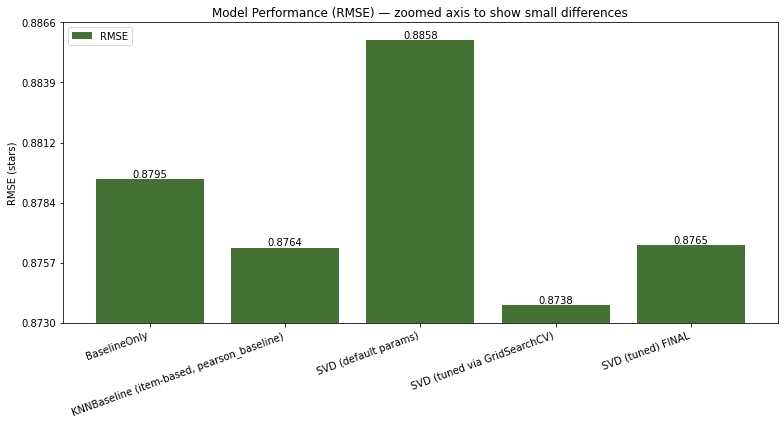

Note: Y-axis is zoomed to make small RMSE differences easier to see. Lower is better.


In [50]:
# RMSE chart (honest scale + optional zoomed inset)
# Goal: show differences without exaggerating them.

# --- Order of models exactly as your summary table ---
order = [
    "BaselineOnly",
    "KNNBaseline (item-based, pearson_baseline)",
    "SVD (default params)",
    "SVD (tuned via GridSearchCV)",
    "SVD (tuned) FINAL"
]

plot_df = results_summary.copy()
plot_df = plot_df[plot_df["Model"].isin(order)].copy()
plot_df["Model"] = pd.Categorical(plot_df["Model"], categories=order, ordered=True)
plot_df = plot_df.sort_values("Model")

labels = plot_df["Model"].astype(str).tolist()
rmse = plot_df["RMSE"].astype(float).values

x = np.arange(len(labels))

# ---- Zoomed range (but includes explicit bottom tick) ----
rmse_min, rmse_max = rmse.min(), rmse.max()
pad = 0.0008
ymin = rmse_min - pad
ymax = rmse_max + pad

fig, ax = plt.subplots(figsize=(11, 6))

bars = ax.bar(x, rmse, label="RMSE", color="#447234")

ax.set_title("Model Performance (RMSE) — zoomed axis to show small differences")
ax.set_ylabel("RMSE (stars)")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20, ha="right")

# Set y-limits (zoomed)
ax.set_ylim(ymin, ymax)

# Force y-axis ticks to include the bottom starting point number
ticks = np.linspace(ymin, ymax, 6)  # 6 ticks including bottom + top
ax.set_yticks(ticks)
ax.set_yticklabels([f"{t:.4f}" for t in ticks])

# Value labels on bars (4 decimals)
for b, v in zip(bars, rmse):
    ax.text(b.get_x() + b.get_width()/2, v, f"{v:.4f}", ha="center", va="bottom")

ax.legend(loc="upper left")

plt.savefig('rmse.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

print("Note: Y-axis is zoomed to make small RMSE differences easier to see. Lower is better.")



## Model change justification: kNN vs SVD
#### Why kNN vs Matrix Factorization?

kNN collaborative filtering is intuitive and interpretable: it recommends movies similar to those a user (or similar users) liked. However, MovieLens is sparse, and similarity methods can be limited when overlap is small.

Matrix factorization (SVD) learns compact latent representations of users and movies from all observed ratings, which often generalizes better in sparse settings. I therefore use kNN as a collaborative filtering baseline and SVD as the final candidate model.


### Tuned SVD explanation
#### Tuned SVD
Tuning helps balance underfitting vs overfitting by adjusting:

- Model capacity (n_factors)

- Training duration (n_epochs)

- Regularization (reg_all)

- Learning rate (lr_all)

I tune SVD using cross-validation on training data, then evaluate the selected model once on a holdout test set.


In [51]:
# Tuned SVD 
# Grid search SVD hyperparameters (train only)
param_grid = {
    "n_factors": [50, 100, 150],
    "n_epochs": [20, 30],
    "lr_all":   [0.002, 0.005],
    "reg_all":  [0.02, 0.05, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3, joblib_verbose=0)
gs.fit(train_data)

print("Best RMSE score:", gs.best_score["rmse"])
print("Best params:", gs.best_params["rmse"])


Best RMSE score: 0.8739863050211824
Best params: {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


## Evaluation


### Metrics justification + final test
#### Evaluation

**Metrics:** RMSE and MAE are appropriate because the target is a numeric rating (0.5–5.0).

- RMSE penalizes large mistakes more heavily, which matters because extreme misrecommendations can reduce trust and engagement.

- MAE is more interpretable as the average number of “stars” the predictions are off.

**Final model selection:** I choose the final model based on cross-validated RMSE/MAE on training data and                  evaluate once on the holdout test set.


In [52]:
# Train best tuned SVD and evaluate on holdout test
best_params = gs.best_params["rmse"]
final_svd = SVD(**best_params, random_state=42)

# Fit on full training set
full_trainset = train_data.build_full_trainset()
final_svd.fit(full_trainset)

# Evaluate once on holdout test set
preds = final_svd.test(testset)
test_rmse = accuracy.rmse(preds, verbose=True)
test_mae  = accuracy.mae(preds, verbose=True)

(test_rmse, test_mae)


RMSE: 0.8754
MAE:  0.6700


(0.8754193610148606, 0.6699772674176766)

## Deployment Demo

This section shows recommendations for (1) an existing user and (2) a new user (cold start).


In [54]:
# You choose an existing userID

# ---- YOU CHOOSE ----
CHOSEN_USER_ID = 599  # <-- replace with any existing userId you want
# --------------------

# Quick validation:
if CHOSEN_USER_ID not in set(ratings["userId"].unique()):
    raise ValueError(f"userId {CHOSEN_USER_ID} not found in dataset.")
else:
    print(f"Using existing userId: {CHOSEN_USER_ID}")


Using existing userId: 599


In [55]:
# Show what the chosen user already liked (from observed ratings)

def top_rated_by_user(user_id, ratings_df, movies_df, k=5):
    """Return the user's top-rated movies from their rating history."""
    user_hist = ratings_df[ratings_df["userId"] == user_id].merge(movies_df, on="movieId", how="left")
    return user_hist.sort_values("rating", ascending=False)[["userId", "movieId", "title", "rating"]].head(k)

print("User's top-rated movies (from available ratings):")
top_rated_by_user(CHOSEN_USER_ID, ratings, movies, k=5)


User's top-rated movies (from available ratings):


,userId,movieId,title,rating
1575,599,6874,Kill Bill: Vol. 1 (2003),5.0
966,599,3160,Magnolia (1999),5.0
340,599,951,His Girl Friday (1940),5.0
285,599,741,Ghost in the Shell (Kôkaku kidôtai) (1995),5.0
1547,599,6711,Lost in Translation (2003),5.0


In [56]:
# Top-N recommender function + existing user recommendations

movie_id_to_title = dict(zip(movies["movieId"], movies["title"]))

def top_n_recs_for_user(algo, trainset, user_id_raw, n=5):
    """Return Top-N recommendations for an existing user.

    Steps:
    1) Identify movies the user already rated in the training set
    2) Predict ratings for all unseen movies
    3) Sort by predicted rating and return the Top-N
    """
    inner_uid = trainset.to_inner_uid(user_id_raw)

    rated_inner_iids = {iid for (iid, _) in trainset.ur[inner_uid]}
    all_inner_iids = set(range(trainset.n_items))
    unseen_inner_iids = list(all_inner_iids - rated_inner_iids)

    scored = []
    for inner_iid in unseen_inner_iids:
        raw_iid = int(trainset.to_raw_iid(inner_iid))
        est = algo.predict(user_id_raw, raw_iid).est
        scored.append((raw_iid, est))

    scored.sort(key=lambda x: x[1], reverse=True)
    top = scored[:n]

    return pd.DataFrame([{
        "userId": int(user_id_raw),
        "movieId": mid,
        "title": movie_id_to_title.get(mid, "Unknown"),
        "predicted_rating": float(est)
    } for mid, est in top])

# Generate Top-5 recommendations for the chosen existing user
top_n_recs_for_user(final_svd, full_trainset, CHOSEN_USER_ID, n=5)


,userId,movieId,title,predicted_rating
0,599,1217,Ran (1985),3.548855
1,599,905,It Happened One Night (1934),3.518923
2,599,56782,There Will Be Blood (2007),3.500353
3,599,1041,Secrets & Lies (1996),3.495586
4,599,933,To Catch a Thief (1955),3.494897


### New User Simulation

Collaborative filtering cannot personalize recommendations for a brand-new user with zero ratings. A standard solution is to ask the user to rate a small number of popular movies to seed the model. I simulate this by creating a new user, adding 5 initial ratings, refitting the model on training data, and generating Top-5 recommendations.


In [57]:
# Find 'starter' movies for a new user to rate (popular movies create overlap)

def popular_movies(ratings_df, movies_df, min_ratings=200, top_n=30):
    """Return popular and well-rated movies for seeding or fallback recommendations."""
    counts = ratings_df.groupby("movieId").size().rename("num_ratings")
    means = ratings_df.groupby("movieId")["rating"].mean().rename("avg_rating")
    pop = pd.concat([counts, means], axis=1).reset_index()
    pop = pop.merge(movies_df, on="movieId", how="left")
    pop = pop[pop["num_ratings"] >= min_ratings].sort_values(
        ["num_ratings", "avg_rating"], ascending=False
    )
    return pop[["movieId", "title", "num_ratings", "avg_rating"]].head(top_n)

starter_list = popular_movies(ratings, movies, min_ratings=200, top_n=30)
starter_list


,movieId,title,num_ratings,avg_rating
314,356,Forrest Gump (1994),329,4.164134
277,318,"Shawshank Redemption, The (1994)",317,4.429022
257,296,Pulp Fiction (1994),307,4.197068
510,593,"Silence of the Lambs, The (1991)",279,4.161290
1938,2571,"Matrix, The (1999)",278,4.192446
224,260,Star Wars: Episode IV - A New Hope (1977),251,4.231076
418,480,Jurassic Park (1993),238,3.750000
97,110,Braveheart (1995),237,4.031646
507,589,Terminator 2: Judgment Day (1991),224,3.970982
461,527,Schindler's List (1993),220,4.225000


In [58]:
# create a new user and enter a few ratings

# Create a new userId not used in the dataset
new_user_id = int(ratings["userId"].max() + 1)

# Choose movieIds from starter_list and assign ratings
# Example seed ratings (edit these to your picks)
new_user_ratings = [
    (new_user_id, 1, 5.0),    # Toy Story (1995) usually movieId 1 in MovieLens
    (new_user_id, 2571, 4.5), # Matrix (1999) often 2571
    (new_user_id, 296, 4.0),  # Pulp Fiction (1994) often 296
    (new_user_id, 593, 4.5),  # Silence of the Lambs (1991) often 593
    (new_user_id, 318, 5.0),  # Shawshank Redemption (1994) often 318
]

new_user_ratings_df = pd.DataFrame(new_user_ratings, columns=["userId", "movieId", "rating"])
new_user_ratings_df.merge(movies, on="movieId", how="left")[["userId","movieId","title","rating"]]


,userId,movieId,title,rating
0,611,1,Toy Story (1995),5.0
1,611,2571,"Matrix, The (1999)",4.5
2,611,296,Pulp Fiction (1994),4.0
3,611,593,"Silence of the Lambs, The (1991)",4.5
4,611,318,"Shawshank Redemption, The (1994)",5.0


In [59]:
### Train “final tuned SVD” including the new user (personalized cold-start resolution)
# append the new ratings to the training data and refit the tuned SVD.
# then recommend top-5
# already have best_params from GridSearchCV earlier
# best_params = gs.best_params["rmse"]

reader = Reader(rating_scale=(0.5, 5.0))

# IMPORTANT: add new user's ratings to TRAIN ONLY (do not touch holdout test)
aug_train_df = pd.concat([train_df, new_user_ratings_df], ignore_index=True)

aug_train_data = Dataset.load_from_df(aug_train_df[["userId","movieId","rating"]], reader)
aug_full_trainset = aug_train_data.build_full_trainset()

final_svd_new = SVD(**best_params, random_state=42)
final_svd_new.fit(aug_full_trainset)

# Recommend for the new user
top5_new_user = top_n_recs_for_user(final_svd_new, aug_full_trainset, new_user_id, n=5).reset_index(drop=True)
top5_new_user


,userId,movieId,title,predicted_rating
0,611,3468,"Hustler, The (1961)",4.640310
1,611,2318,Happiness (1998),4.618084
2,611,898,"Philadelphia Story, The (1940)",4.616641
3,611,1262,"Great Escape, The (1963)",4.613325
4,611,1283,High Noon (1952),4.609720


### Cold-start fallback strategy
Cold-start fallback (true new user with 0 ratings)

If a user provides zero ratings, collaborative filtering cannot personalize. In that case, a practical fallback is to recommend movies that are both popular (many ratings) and highly rated (high average rating). This provides reasonable defaults until enough user feedback is collected.


In [60]:
# Fallback recommendations for 0-rating user

fallback_recs = popular_movies(ratings, movies, min_ratings=200, top_n=10)\
    .sort_values(["avg_rating","num_ratings"], ascending=False)\
    .head(5)[["movieId","title","num_ratings","avg_rating"]]

print("Fallback Top-5 for a true cold-start user (0 ratings):")
fallback_recs.reset_index(drop=True)


Fallback Top-5 for a true cold-start user (0 ratings):


,movieId,title,num_ratings,avg_rating
0,318,"Shawshank Redemption, The (1994)",317,4.429022
1,260,Star Wars: Episode IV - A New Hope (1977),251,4.231076
2,527,Schindler's List (1993),220,4.225000
3,296,Pulp Fiction (1994),307,4.197068
4,2571,"Matrix, The (1999)",278,4.192446


In [61]:
# Results summary table (CV + Holdout)

results_summary = pd.DataFrame([
    {
        "Model": "BaselineOnly",
        "Validation Method": "3-Fold CV (train only)",
        "RMSE": baseline_rmse,
        "MAE": baseline_mae
    },
    {
        "Model": "KNNBaseline (item-based, pearson_baseline)",
        "Validation Method": "3-Fold CV (train only)",
        "RMSE": knn_rmse,
        "MAE": knn_mae
    },
    {
        "Model": "SVD (default params)",
        "Validation Method": "3-Fold CV (train only)",
        "RMSE": svd_rmse,
        "MAE": svd_mae
    },
    {
        "Model": "SVD (tuned via GridSearchCV)",
        "Validation Method": "3-Fold CV (train only)",
        "RMSE": gs.best_score["rmse"],
        "MAE": gs.best_score["mae"]
    },
    {
        "Model": "SVD (tuned) FINAL",
        "Validation Method": "Holdout Test (20%)",
        "RMSE": test_rmse,
        "MAE": test_mae
    }
])

# Pretty formatting
results_summary["RMSE"] = results_summary["RMSE"].astype(float).round(4)
results_summary["MAE"]  = results_summary["MAE"].astype(float).round(4)

results_summary


,Model,Validation Method,RMSE,MAE
0,BaselineOnly,3-Fold CV (train only),0.8796,0.6802
1,"KNNBaseline (item-based, pearson_baseline)",3-Fold CV (train only),0.8756,0.6690
2,SVD (default params),3-Fold CV (train only),0.8858,0.6831
3,SVD (tuned via GridSearchCV),3-Fold CV (train only),0.8740,0.6733
4,SVD (tuned) FINAL,Holdout Test (20%),0.8754,0.6700


## Conclusion

#### Summary of results

  I compared a baseline model, neighborhood collaborative filtering (kNN), and matrix factorization (SVD).

  Hyperparameter tuning improved SVD’s cross-validated performance and produced strong holdout test results (RMSE/MAE).

  The system generates Top-5 recommendations for existing users and can handle new users via seeded ratings or popularity-based   fallback.
  
##### On the holdout test set, the tuned SVD achieved RMSE ≈ 0.88, meaning predictions are typically within about ~0.9 stars of the   true rating.

#### Business implications

  Personalized recommendations can reduce choice overload and improve engagement and retention.

  A cold-start strategy is necessary for new users and new content.

#### Limitations

  Sparse rating matrix limits personalization for low-activity users

  No user demographics or rich item metadata

  Offline RMSE/MAE does not fully capture business KPIs (e.g., click-through, watch-time)

#### Next steps

Add a simple hybrid (content + CF) using genres/tags for cold-start

Evaluate with ranking metrics (Precision@K / Recall@K) and online A/B testing

Incorporate implicit feedback (clicks, watch-time) for production use
